<a href="https://colab.research.google.com/github/jaderAdriel/Clorofila-a/blob/main/Projeto_pibic_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Bilbiotecas { display-mode: "form" }
!pip install --upgrade gspread
!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from gspread import *
import numpy as np

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


Panilha reservatorio Ceraima: [CND-CER-002](https://docs.google.com/spreadsheets/d/16gMgMV5wRAF83w7i_q9JwA03kGQprFkMjQojLgNDVtA/edit?usp=sharing)

Panilha reservatorio Ilheus: [LES-IGP-001](https://docs.google.com/spreadsheets/d/1xK1tuD3eTHktwVzsmqZEcFKcjut-eak2E21AxtdTUek/edit?ouid=115855923033913247098&usp=sheets_home&ths=true)

In [ ]:
#@title Insira a url da panilha e o nome do reservatorio e o parâmetro { run: "auto", form-width: "50%", display-mode: "form" }

url1 = "https://docs.google.com/spreadsheets/d/16gMgMV5wRAF83w7i_q9JwA03kGQprFkMjQojLgNDVtA/edit#gid=367972063" #@param {type:"string"}
reservatory1 = "CND-CER-002" #@param {type:"string"}
url2 = "https://docs.google.com/spreadsheets/d/1xK1tuD3eTHktwVzsmqZEcFKcjut-eak2E21AxtdTUek/edit#gid=347055721" #@param {type:"string"}
reservatory2 = "LES-IGP-001" #@param {type:"string"}



In [ ]:
#@title  { run: "auto", display-mode: "form" }
#@title  { run: "auto" }
#@title  { form-width: "50%" }
#@markdown Select if you want compare parametes on the same reservoirs, compare same parameter on diferents reservoirs or dont compare
compare = "Reservoirs" #@param ["Parameters", "Reservoirs", "None"]
parameter1 = "Temperatura" #@param ["Clorofila a", "Colif. termo", "Condutividade", "Salinidade", "Sólidos em suspensão", "Sólidos totais", "STD", "Temperatura", "Turbidez", "Alcalinidade total", "DBO", "DQO", "Nitrogênio Nitrato", "N-NH3", "N Total", "OD", "pH", "P Total", "% Saturação de Oxigênio Dissolvido", "Cloreto", "Ortofosfato solúvel", "Temperatura do Ar", "Transparência da Água"]
#@markdown only if you selected parameters option in 'compare' :) 
parameter2 = "Cloreto" #@param ["Clorofila a", "Colif. termo", "Condutividade", "Salinidade", "Sólidos em suspensão", "Sólidos totais", "STD", "Temperatura", "Turbidez", "Alcalinidade total", "DBO", "DQO", "Nitrogênio Nitrato", "N-NH3", "N Total", "OD", "pH", "P Total", "% Saturação de Oxigênio Dissolvido", "Cloreto", "Ortofosfato solúvel", "Temperatura do Ar", "Transparência da Água"]


In [ ]:
#@title Functions { form-width: "20%", display-mode: "form" }


from functools import reduce


def moreConcentratedCampaign (reservoir):
     return reduce(lambda a,b: a if a['VALOR'] > b['VALOR'] else b,reservoir)


def cleanDate(date):
    return [int(i) for i in date.split('/')]


def relatedCampaign(campaign, campaignCollection):
    _, month, year =  cleanDate(campaign['COLETA'])

    i = 0
    while i < 5:
        intervalOfMonths = [month-i, month, month+i]
        for campaignX in campaignCollection:
            _, monthX, yearX =  cleanDate(campaignX['COLETA'])
            if yearX == year and monthX in intervalOfMonths: 
                return campaignX
        i += 1
    return False


def xAxis (campaign,reservoir):
    x, month, year = cleanDate(campaign['COLETA'])
    return f'{reservoir} ({month_name(month)} {year})'


def month_name(mes):
    x = [ 
         'Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun', 
         'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez',
    ]
    return x[int(mes)-1]


def select(startDate, finalDate, dic):

    selectedDic = []

    startYear, startMonth, *_ = startDate.split('-')
    finalYear, finalMonth, *_ = finalDate.split('-')
    
    for campaign in dic:
        day, month, year = campaign['COLETA'].split('/')
        periodo = year + month

        if startYear+startMonth <= periodo <= finalYear+finalMonth: 
            selectedDic.append(campaign)
            

    return selectedDic

def valid_value(value):
    
    validValue = ''
    value = str(value)

    for i in value:
        if i == ',': validValue += '.';
        elif i == '<': validValue += '';
        else: validValue += i;

    try: return float(validValue)
    except: return value


def get_parameter(parameter, worksheets):
    
    worksheet = worksheets.get_worksheet(0)
    collectionDates = worksheets.get_worksheet(1)
    dic = []
    dates =  {}

    for campanha, date in collectionDates.get_all_values():
        dates[campanha] = date

    for cell in worksheet.get_all_values():
        if parameter in cell :
            campanha = {}
            campanha['NOME'] = cell[1]
            campanha['UNIDADE'] = cell[3]
            campanha['VALOR'] = valid_value(cell[-1])
            campanha['COLETA'] = dates[cell[-2]]

            dic.append(campanha)

    return dic

def equivalentsCampaigns(reservoirX, reservoirY):
    y = [ [ ],[ ] ]
    x = [ ]
    checked = [ ]

    for cpnX in reservoirX:
        _, monthX, yearX = cpnX['COLETA'].split('/')
        rangeMonth = [int(monthX)-1 , int(monthX), int(monthX)+1]

        for cpnY in reservoirY:
            _, monthY, yearY = cpnY['COLETA'].split('/')

            if not(yearY == yearX and int(monthY) in rangeMonth): continue

            a = (monthX, yearX)
            b = (monthY, yearY)

            if a in checked or b in checked: continue
            
            checked.append(a)
            checked.append(b)
            y[0].append(cpnX['VALOR']); y[1].append(cpnY['VALOR'])
            x.append(f'{month_name(monthX)}/{month_name(monthY)}-{yearY}')

            break    
            
    return [x, y]


def compareMoreConcentratedCampaign(a, b, x1 = 1, x2 = 2):

    moreConcentrated = moreConcentratedCampaign(a)
    campaignRelatedTo = relatedCampaign(moreConcentrated, b)

    x1 = xAxis(moreConcentrated, x1)
    x2 = xAxis(campaignRelatedTo, x2)
    
    axis= [ [x1, x2], [] ]
    axis[1] = [ moreConcentrated['VALOR'],campaignRelatedTo['VALOR']]
   
    return axis

In [ ]:
#@title Graph { form-width: "25%" }


def compareReservoirs(dic1, dic2, reservatory1, reservatory2, ylabel = ''):

    parameter = dic1[0]['NOME']
    
    x, y = equivalentsCampaigns(dic1, dic2)

    plt.plot(x, y[0], color='r', label='subplot1') 
    plt.plot(x, y[1], color='b', label='subplot2') 

    plt.scatter(x, y[0], color='red')
    for w, z in zip(x, y[0]):  # adiciona um texto para cada ponto XY
            plt.text(w,z+0.3, z, color='red', horizontalalignment='center', alpha=1)

    plt.scatter(x, y[1], color='blue')
    for w, z in zip(x, y[1]):  # adiciona um texto para cada ponto XY
            plt.text(w,z+0.3, z, color='blue', horizontalalignment='center', alpha=1)

    rotation = 0
    if len(x) > 12: rotation = len(x) * 1.2

    plt.title(f'{parameter} ({reservatory1} X {reservatory2})')
    plt.autoscale(axis = 'x', tight=True)

    plt.ylabel(dic1[0]['UNIDADE'])
    plt.xticks(rotation = rotation)

    plt.gcf().set_size_inches(15, 6)

    plt.legend([reservatory1, reservatory2])

    return 


def compareParameter(dic1, dic2, reservatory1):

    subplot1 = []
    subplot2 = []
    parameter1 = dic1[0]['NOME']
    parameter2 = dic2[0]['NOME']
    unidade1 = dic1[0]['UNIDADE']
    unidade2 = dic2[0]['UNIDADE']
    x = []

    for campanha1 in dic1:
        found = False
        for campanha2 in dic2:
            if not(campanha2['COLETA'] == campanha1['COLETA']): continue
            subplot1.append(campanha1['VALOR'])
            subplot2.append(campanha2['VALOR'])
            found = True
            break
        if found: x.append(campanha1['COLETA'])

    fig, ax1 = plt.subplots()
    ax1.plot(x, subplot1, color='r', label='sin')
    ax1.legend([parameter1], facecolor="white", loc='upper left', bbox_to_anchor= (0.75, 0.95), 
               ncol=2, borderaxespad=0, frameon=False)
    
    ax1.scatter(x, subplot1, color='red')
    ax1.set_ylabel(f'{parameter1} ({unidade1})')
    
    ax2 = plt.twinx(ax1)
    ax2.plot(x, subplot2, color='b', label='cos')
    ax2.legend([parameter2], facecolor="white", loc='upper left', bbox_to_anchor= (0.75, 0.90), 
                ncol=2,borderaxespad=0, frameon=False)
    
    ax2.scatter(x, subplot2, color='blue')
    ax2.set_ylabel(f'{parameter2} ({unidade2})')

    rotation = 0
    if len(x) > 9: rotation = len(x) * 1.2

    plt.gcf().set_size_inches(15, 6)
    ax1.autoscale(axis = 'x', tight=True)
    ax1.set_xticklabels(x, rotation = rotation)
    plt.title(f'{parameter1} X {parameter2} in {reservatory1}')
    
    return 


def lineGraph(dic, reservoir = 'x'):
    parameter = dic[0]['NOME']
    unidade = dic[0]['UNIDADE']
    x = []
    y = []

    for campaign in dic:
        y.append(campaign['VALOR'])
        date = campaign['COLETA'].split('/')
        date = month_name(date[1]) + ' ' + date[2]
        x.append(date)

    plt.gcf().set_size_inches(15, 5)
    plt.autoscale(axis = '', tight=True)
    plt.xticks(rotation = 40)
    plt.title(f'{parameter} in {reservoir}')
    plt.ylabel(unidade)
    plt.plot(x, y, color='blue')
    plt.scatter(x, y, color='blue')


def graphCompareMoreConcentrated(reservoirX, reservoirY, labelX, labelY):
    parameter = reservoirX[0]['NOME']
    unidade = reservoirX[0]['UNIDADE']
    subplotsAxis = [ [], [] ]

    subplotsAxis[0] = compareMoreConcentratedCampaign(reservoirX, reservoirY, labelX, labelY)
    subplotsAxis[1] = compareMoreConcentratedCampaign(reservoirY, reservoirX, labelY, labelX)
    
    plt.subplots(figsize=(15, 5)) 
    i = 0
    subplot = [[],[]]
    for ax, ay in subplotsAxis:
        subplot[i] =  plt.subplot(1, 2, i+1)
        subplot[i].margins(0.1, 0.1)
        subplot[i].bar(ax, ay)
        subplot[i].set_xlabel('Reservátorios')
        subplot[i].set_ylabel(f'{parameter} - ({unidade})')

        for x, y in zip(ax, ay):  # adiciona um texto para cada ponto XY
            subplot[i].text(x,y, y, color='black', horizontalalignment='center', alpha=1)

        i += 1

    subplot[0].set_title('Campanha com maior concentração no {0}\n X \ncampanha no {1} no mesmo periodo'.format(labelX, labelY))
    subplot[1].set_title('Campanha com maior concentração no {0}\n X \ncampanha no {1} no mesmo periodo'.format(labelY,labelX))




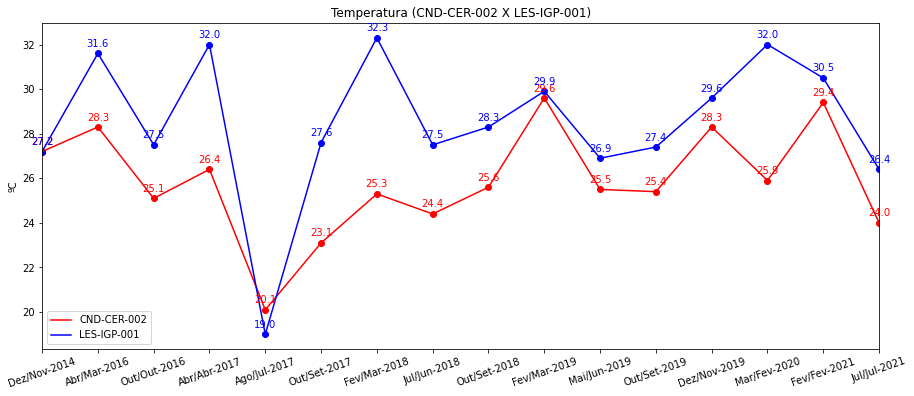

In [ ]:
#@title Gŕafico { form-width: "50%", display-mode: "form" }
#@markdown Select the reservoir, ignore if you are going to compare both 
graph = "reservoir1" #@param ["reservoir1", "reservoir2"]
#@markdown select the period you want
startDate = "2000-08-01" #@param {type:"date"}
finalDate = "2022-12-25" #@param {type:"date"}

url = url1 if graph == "reservoir1" else url2
reservoir = reservatory1 if graph == "reservoir1" else reservatory2

dics = [gc.open_by_url(url)]
dics[0] = get_parameter(parameter1, dics[0])

dics[0] = select(startDate, finalDate, dics[0])

if compare == 'None': lineGraph(dics[0], reservoir)

if compare == 'Reservoirs': 
    dics = [gc.open_by_url(url1), gc.open_by_url(url2)]
    dics[0] = select(startDate, finalDate ,get_parameter(parameter1, dics[0]))
    dics[1] = select(startDate, finalDate ,get_parameter(parameter1, dics[1]))
    compareReservoirs(dics[0], dics[1], reservatory1, reservatory2)
    
    
elif compare == 'Parameters':
    dics = [gc.open_by_url(url), gc.open_by_url(url)]
    dics[0] = select(startDate, finalDate ,get_parameter(parameter1, dics[0]))
    dics[1] = select(startDate, finalDate ,get_parameter(parameter2, dics[1]))
    compareParameter(dics[0], dics[1], reservoir)

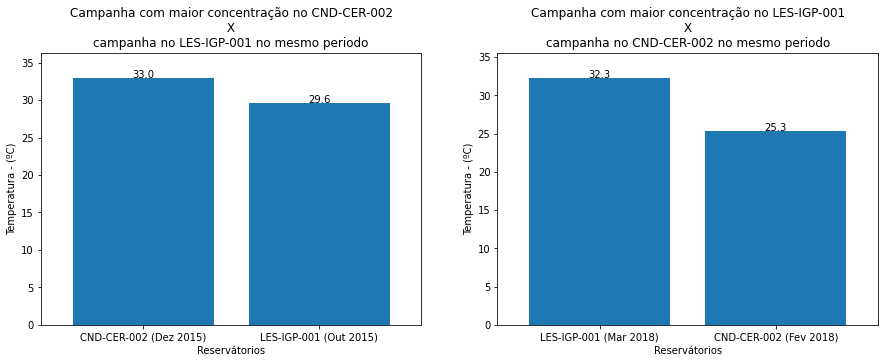

In [ ]:

graphCompareMoreConcentrated(dics[0], dics[1],reservatory1, reservatory2)
